In [82]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

In [83]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points to generate (hourly readings for 90 days)
n_samples = 24 * 90

# Start date and time
start_date = datetime(2025, 1, 1, 0, 0, 0)

In [84]:
# Function to generate normal operating data
def generate_normal_data(n_samples):
    data = {
        "timestamp": [start_date + timedelta(hours=i) for i in range(n_samples)],
        "vibration_rms": np.random.normal(0.8, 0.15, n_samples),              # g (gravitational force)
        "motor_temp_C": np.random.normal(65, 4, n_samples),                  # Celsius
        "spindle_current_A": np.random.normal(15, 1.5, n_samples),             # Amperes
        "rpm": np.random.normal(3000, 200, n_samples),                       # Revolutions per minute
        "tool_usage_min": np.zeros(n_samples),                               # Tool usage increases over time
        "coolant_temp_C": np.random.normal(30, 2, n_samples),                # Coolant temperature
        "cutting_force_N": np.random.normal(200, 15, n_samples),             # Newtons
        "power_consumption_W": np.random.normal(5000, 400, n_samples),       # Power in watts
        "acoustic_level_dB": np.random.normal(75, 3, n_samples),             # Decibel level
        "machine_hours_today": np.zeros(n_samples),                          # Random 6-15 hrs/day
        "total_machine_hours": np.zeros(n_samples),                          # Cumulative use
    }
    
    # Generate machine hours today (random 6-15 hours per day)
    current_day = data["timestamp"][0].day
    daily_hours = random.uniform(6, 15)
    
    cumulative_hours = 5000  # Start with some existing hours
    
    for i in range(n_samples):
        day = data["timestamp"][i].day
        
        # If new day, generate new daily hours
        if day != current_day:
            current_day = day
            daily_hours = random.uniform(6, 15)
        
        data["machine_hours_today"][i] = daily_hours
        cumulative_hours += 1  # Add one hour per sample
        data["total_machine_hours"][i] = cumulative_hours
    
    # Tool usage increases over time, resetting after maintenance
    tool_usage = 0
    for i in range(n_samples):
        # Tool usage increases with time
        if i > 0:
            # Reset tool usage periodically (simulating tool change)
            if tool_usage > 4000:
                tool_usage = 0
            else:
                tool_usage += random.uniform(10, 20)
        
        data["tool_usage_min"][i] = tool_usage
    
    return pd.DataFrame(data)

In [85]:
# Generate base normal data
df = generate_normal_data(n_samples)

# Define anomaly types and their impact on sensor readings
anomaly_types = {
    "tool_wear": {
        "vibration_rms": 1.5,      # Multiplier for normal value
        "cutting_force_N": 1.3,
        "acoustic_level_dB": 1.2,
        "tool_usage_min": 1.0,     # Tool wear is actually reflected by the usage time already
        "severity_impact": 0.7,    # How much this affects health score (0-1)
        "progression_rate": 1.2    # How quickly this issue progresses
    },
    "tool_break": {
        "vibration_rms": 2.5,
        "cutting_force_N": 0.7,    # Cutting force drops when tool breaks
        "acoustic_level_dB": 1.5,
        "spindle_current_A": 1.3,
        "severity_impact": 0.9,
        "progression_rate": 1.8
    },
    "motor_overheating": {
        "motor_temp_C": 1.4,
        "power_consumption_W": 1.2,
        "spindle_current_A": 1.15,
        "severity_impact": 0.8,
        "progression_rate": 1.0
    },
    "coolant_failure": {
        "coolant_temp_C": 1.5,
        "motor_temp_C": 1.2,       # Motor gets hotter when coolant fails
        "severity_impact": 0.85,
        "progression_rate": 1.5
    },
    "power_supply_issue": {
        "power_consumption_W": 1.3,
        "spindle_current_A": 0.85,  # Current can be unstable
        "rpm": 0.9,                # RPM might drop slightly
        "severity_impact": 0.75,
        "progression_rate": 0.8
    }
}


In [86]:
# Generate health score and maintenance requirements
def generate_health_and_maintenance(df):
    """
    Generate health scores and maintenance days with clear patterns:
    1. Health decreases over time
    2. Maintenance days are directly related to health (low health = maintenance needed soon)
    3. After maintenance, health improves
    """
    # Initialize columns
    df['machine_health_score'] = np.zeros(len(df))
    df['days_to_maintenance'] = np.zeros(len(df))
    df['is_anomaly'] = np.zeros(len(df))
    df['anomaly_type'] = 'normal'
    df['anomaly_severity'] = np.zeros(len(df))
    
    # Base degradation model: machine health decreases over time
    # Start with full health
    current_health = 100.0
    
    # Health degrades with usage
    health_decay_per_hour = 0.02
    
    # Maintenance schedule - approximately every 30 days
    maintenance_points = []
    for i in range(1, 4):  # 3 maintenance events in 90 days
        day = i * 30 + random.randint(-5, 5)  # Add some randomness
        hour = random.randint(0, 23)
        maintenance_points.append(day * 24 + hour)
    
    # Set initial health scores based on natural degradation
    for i in range(len(df)):
        if i > 0:
            # Natural health degradation
            usage_factor = 1.0 + (df.loc[i, 'total_machine_hours'] - df.loc[i-1, 'total_machine_hours']) / 1000
            current_health -= health_decay_per_hour * usage_factor
            
            # Health can't go below 20 just from normal usage
            current_health = max(20, current_health)
        
        # Set health score
        df.loc[i, 'machine_health_score'] = current_health
        
        # Calculate days to maintenance based on health score
        # Lower health = fewer days to maintenance
        if current_health > 80:
            days_to_maint = 30  # If health is good, maintenance is far away
        elif current_health > 60:
            days_to_maint = 20
        elif current_health > 40:
            days_to_maint = 10
        else:
            days_to_maint = max(0, int(current_health / 10))
        
        df.loc[i, 'days_to_maintenance'] = days_to_maint
        
        # Check if this is a maintenance point
        if i in maintenance_points:
            # After maintenance, health improves significantly
            current_health = 100.0  # Reset to full health
            df.loc[i, 'days_to_maintenance'] = 30  # Reset maintenance days
    
    # Add some noise to make it more realistic
    df['machine_health_score'] += np.random.normal(0, 1, len(df))
    df['machine_health_score'] = df['machine_health_score'].clip(0, 100)
    
    return df

In [87]:
# Apply base health and maintenance patterns
df = generate_health_and_maintenance(df)

In [88]:
def introduce_anomalies(df, anomaly_percentage=0.15):
    """
    Introduces anomalies with progressive deterioration patterns,
    realistic intermixing of anomaly types, and noisy behavior.
    """
    total_hours = len(df)
    total_anomaly_hours = int(total_hours * anomaly_percentage)

    min_sequence_length = 6
    max_sequence_length = 48

    sequences = []
    remaining_hours = total_anomaly_hours

    while remaining_hours > 0:
        seq_length = min(random.randint(min_sequence_length, max_sequence_length), remaining_hours)
        sequences.append(seq_length)
        remaining_hours -= seq_length

    random.shuffle(sequences)
    used_ranges = []

    for seq_length in sequences:
        intermix = random.random() < 0.4  # 40% chance of intermixing
        if intermix and seq_length > 12:
            split_point = random.randint(4, seq_length - 4)
            part1_len = split_point
            part2_len = seq_length - split_point

            for part_len, offset in [(part1_len, 0), (part2_len, split_point)]:
                anomaly_type = random.choice(list(anomaly_types.keys()))
                anomaly_config = anomaly_types[anomaly_type]

                found = False
                for _ in range(20):
                    start_pos = random.randint(48, len(df) - part_len - 48)
                    if not any(start <= start_pos <= end or start <= start_pos + part_len <= end for start, end in used_ranges):
                        found = True
                        break
                if not found:
                    continue

                used_ranges.append((start_pos, start_pos + part_len))

                for i in range(part_len):
                    pos = start_pos + i
                    base_severity = min(1.0, (i / part_len) * anomaly_config["progression_rate"])
                    severity = base_severity + np.random.normal(0, 0.25)
                    severity = max(0.02, min(1.0, severity))

                    df.loc[pos, 'is_anomaly'] = 1
                    df.loc[pos, 'anomaly_type'] = anomaly_type
                    df.loc[pos, 'anomaly_severity'] = severity

                    for metric, multiplier in anomaly_config.items():
                        if metric in df.columns and metric not in ['severity_impact', 'progression_rate']:
                            if random.random() < 0.4:
                                continue  # simulate sensor dropout
                            effect = 1.0 + (multiplier - 1.0) * severity
                            df.loc[pos, metric] *= effect * np.random.normal(1.0, 0.1)

                    health_impact = -50 * severity * anomaly_config["severity_impact"] + np.random.normal(0, 5)
                    df.loc[pos, 'machine_health_score'] += health_impact
                    df.loc[pos, 'machine_health_score'] = max(0, min(100, df.loc[pos, 'machine_health_score']))

                    current_health = df.loc[pos, 'machine_health_score']
                    if current_health > 80:
                        days_to_maint = 30
                    elif current_health > 60:
                        days_to_maint = 20
                    elif current_health > 40:
                        days_to_maint = 10
                    elif current_health > 20:
                        days_to_maint = 5
                    elif current_health > 10:
                        days_to_maint = 2
                    else:
                        days_to_maint = 0

                    days_to_maint += np.random.normal(0, 2)
                    df.loc[pos, 'days_to_maintenance'] = max(0, min(30, days_to_maint))

        else:
            anomaly_type = random.choice(list(anomaly_types.keys()))
            anomaly_config = anomaly_types[anomaly_type]

            found = False
            for _ in range(20):
                start_pos = random.randint(48, len(df) - seq_length - 48)
                if not any(start <= start_pos <= end or start <= start_pos + seq_length <= end for start, end in used_ranges):
                    found = True
                    break
            if not found:
                continue

            used_ranges.append((start_pos, start_pos + seq_length))

            for i in range(seq_length):
                pos = start_pos + i
                base_severity = min(1.0, (i / seq_length) * anomaly_config["progression_rate"])
                severity = base_severity + np.random.normal(0, 0.15)
                severity = max(0.05, min(1.0, severity))

                df.loc[pos, 'is_anomaly'] = 1
                df.loc[pos, 'anomaly_type'] = anomaly_type
                df.loc[pos, 'anomaly_severity'] = severity

                for metric, multiplier in anomaly_config.items():
                    if metric in df.columns and metric not in ['severity_impact', 'progression_rate']:
                        effect = 1.0 + (multiplier - 1.0) * severity
                        df.loc[pos, metric] *= effect * np.random.normal(1.0, 0.08)

                health_impact = -50 * severity * anomaly_config["severity_impact"] + np.random.normal(0, 3)
                df.loc[pos, 'machine_health_score'] += health_impact
                df.loc[pos, 'machine_health_score'] = max(0, min(100, df.loc[pos, 'machine_health_score']))

                current_health = df.loc[pos, 'machine_health_score']
                if current_health > 80:
                    days_to_maint = 30
                elif current_health > 60:
                    days_to_maint = 20
                elif current_health > 40:
                    days_to_maint = 10
                elif current_health > 20:
                    days_to_maint = 5
                elif current_health > 10:
                    days_to_maint = 2
                else:
                    days_to_maint = 0

                days_to_maint += np.random.normal(0, 1.5)
                df.loc[pos, 'days_to_maintenance'] = max(0, min(30, days_to_maint))

    # 5% random dual-type overlaps
    for _ in range(int(len(df) * 0.005)):
        pos = random.randint(100, len(df) - 100)
        if df.loc[pos, 'is_anomaly'] == 1:
            existing_type = df.loc[pos, 'anomaly_type']
            new_type = random.choice([a for a in anomaly_types if a != existing_type])
            df.loc[pos, 'anomaly_type'] = f"{existing_type}+{new_type}"
            df.loc[pos, 'anomaly_severity'] = min(1.0, df.loc[pos, 'anomaly_severity'] + np.random.uniform(0.1, 0.3))

    return df


In [89]:
# Apply anomalies to the dataset
df = introduce_anomalies(df)

# Add more features that can help with prediction
df["vibration_trend"] = df["vibration_rms"].rolling(window=24, min_periods=1).mean()
df["motor_temp_trend"] = df["motor_temp_C"].rolling(window=24, min_periods=1).mean()
df["power_efficiency"] = df["rpm"] / df["power_consumption_W"] * 1000  # Higher is better
df["tool_wear_rate"] = df["tool_usage_min"].diff().fillna(0)  # Rate of tool wear

# In real data we'd use time series techniques for these, but for our sample:
df["vibration_std_24h"] = df["vibration_rms"].rolling(window=24, min_periods=1).std()
df["temp_rate_change"] = df["motor_temp_C"].diff().fillna(0)
df["current_stability"] = df["spindle_current_A"].rolling(window=12, min_periods=1).std()

# Save the dataset to a CSV file
df.to_csv("cnc_machine_data.csv", index=False)

Generated 2160 data points with 324.0 anomaly points
Dataset saved to cnc_machine_data_improved.csv
Visualizations saved to data_visualization.png

Dataset Summary:
Date range: 2025-01-01 00:00:00 to 2025-03-31 23:00:00
Anomaly types: ['power_supply_issue' 'tool_wear' 'coolant_failure' 'tool_break'
 'motor_overheating' 'motor_overheating+coolant_failure']
Health score range: 35.6 to 100.0
Days to maintenance range: 2.5 to 30.0

Correlation between health score and days to maintenance: 0.9046
Percentage of anomalies in dataset: 15.00%

Anomaly distribution:
- tool_wear: 100 instances (30.9%)
- coolant_failure: 95 instances (29.3%)
- motor_overheating: 54 instances (16.7%)
- power_supply_issue: 39 instances (12.0%)
- tool_break: 35 instances (10.8%)
- motor_overheating+coolant_failure: 1 instances (0.3%)


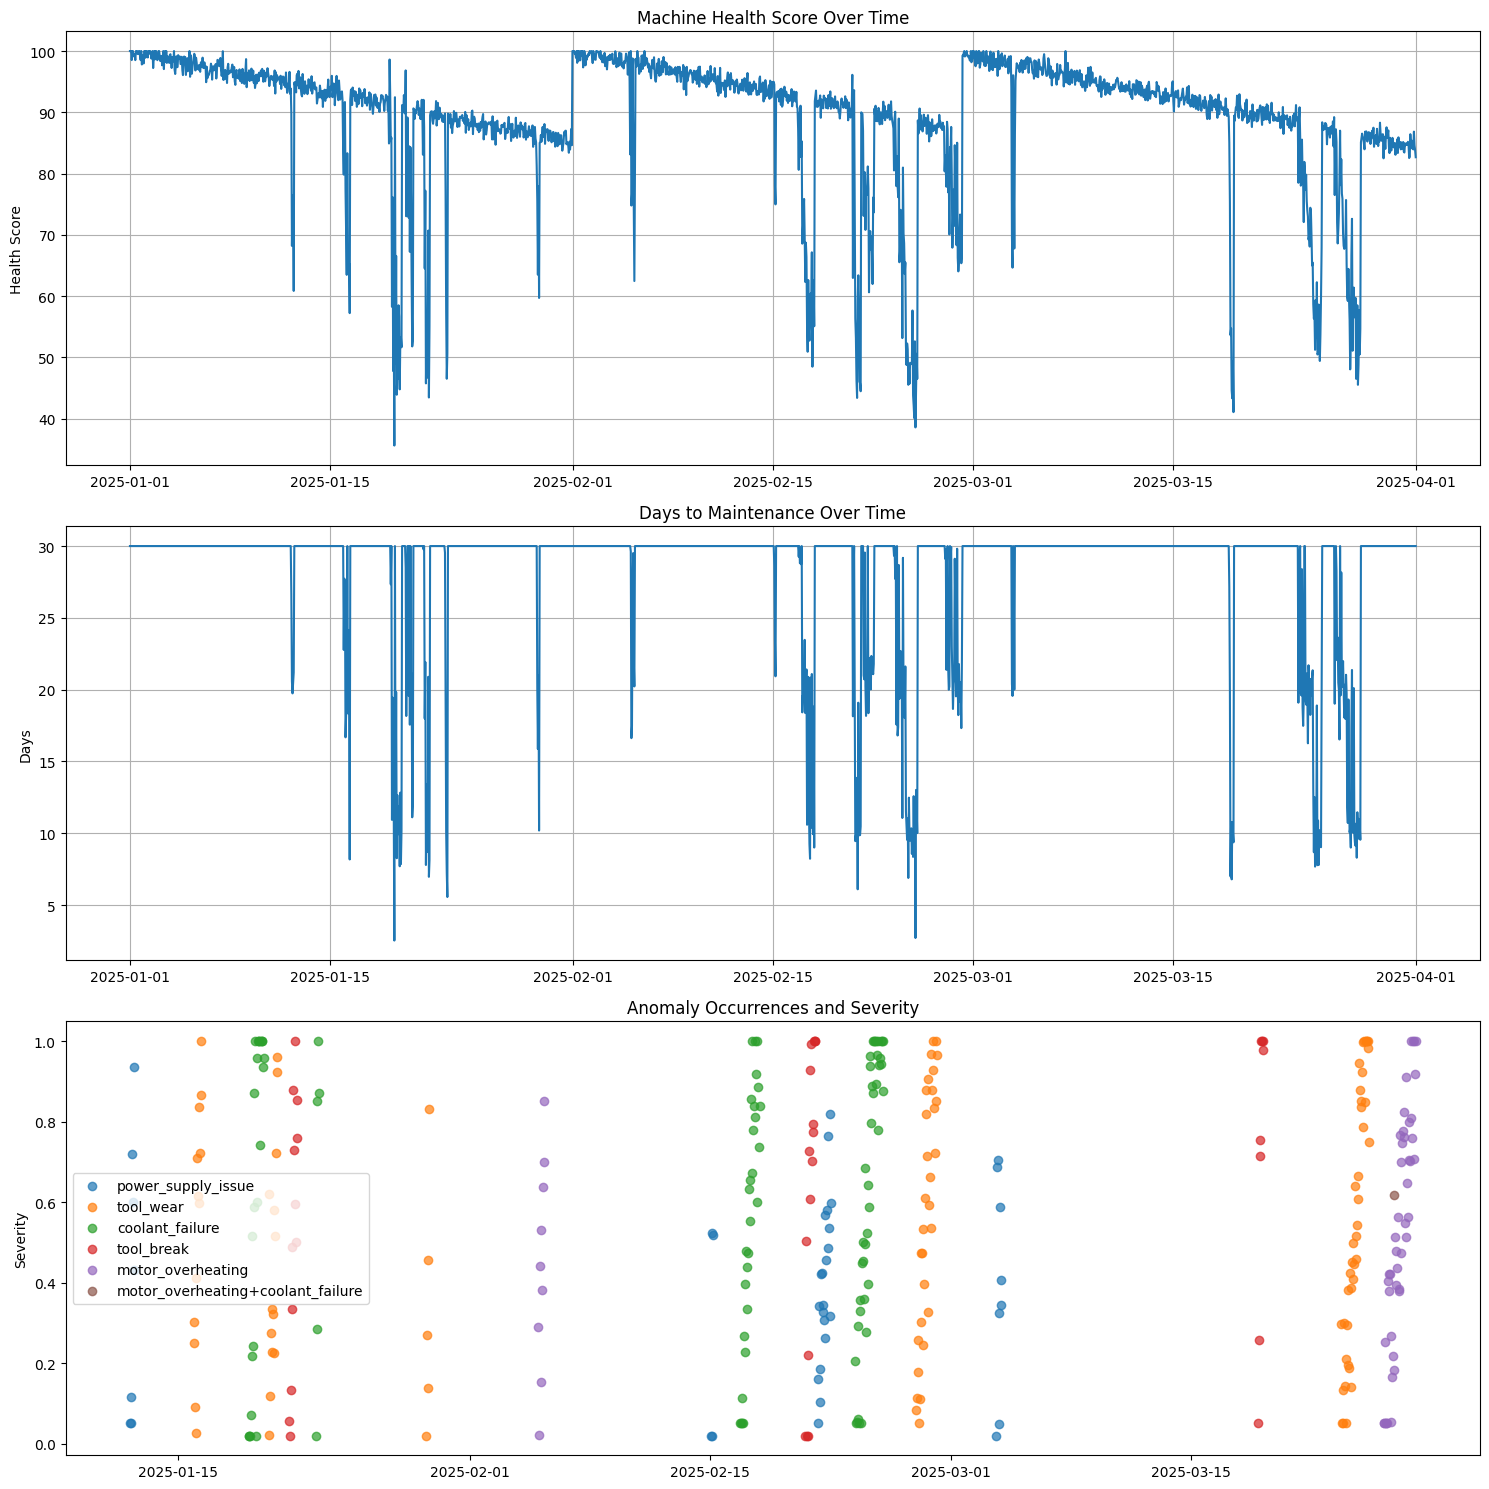

In [90]:
# Visualize the generated data to verify patterns
plt.figure(figsize=(15, 15))

# Plot health scores
plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['machine_health_score'])
plt.title('Machine Health Score Over Time')
plt.ylabel('Health Score')
plt.grid(True)

# Plot days to maintenance
plt.subplot(3, 1, 2)
plt.plot(df['timestamp'], df['days_to_maintenance'])
plt.title('Days to Maintenance Over Time')
plt.ylabel('Days')
plt.grid(True)

# Plot anomaly occurrences
plt.subplot(3, 1, 3)
for anomaly_type in df['anomaly_type'].unique():
    if anomaly_type != 'normal':
        mask = df['anomaly_type'] == anomaly_type
        plt.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'anomaly_severity'], 
                    label=anomaly_type, alpha=0.7)

plt.title('Anomaly Occurrences and Severity')
plt.ylabel('Severity')
plt.legend()
plt.tight_layout()
plt.savefig('data_visualization.png')

print(f"Generated {len(df)} data points with {df['is_anomaly'].sum()} anomaly points")
print(f"Dataset saved to cnc_machine_data_improved.csv")
print(f"Visualizations saved to data_visualization.png")

# Dataset summary
print("\nDataset Summary:")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Anomaly types: {df[df['is_anomaly']==1]['anomaly_type'].unique()}")
print(f"Health score range: {df['machine_health_score'].min():.1f} to {df['machine_health_score'].max():.1f}")
print(f"Days to maintenance range: {df['days_to_maintenance'].min():.1f} to {df['days_to_maintenance'].max():.1f}")

# Display correlation between health score and days to maintenance
health_maint_corr = df['machine_health_score'].corr(df['days_to_maintenance'])
print(f"\nCorrelation between health score and days to maintenance: {health_maint_corr:.4f}")

# Display percentage of anomalies
anomaly_percentage = df['is_anomaly'].mean() * 100
print(f"Percentage of anomalies in dataset: {anomaly_percentage:.2f}%")

# Display anomaly type distribution
anomaly_counts = df[df['is_anomaly']==1]['anomaly_type'].value_counts()
print("\nAnomaly distribution:")
for anomaly_type, count in anomaly_counts.items():
    print(f"- {anomaly_type}: {count} instances ({count/df['is_anomaly'].sum()*100:.1f}%)")